# Practical Bayesian Optimization of Machine Learning Algorithm

**Auteurs du projet**: Vincent LE MEUR, Thomas Levy,Timothée Watrigant

# Sources

L'article étudié est le suivant : https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf

Pour installer un kernel python 2 sur jupyter
http://ipython.readthedocs.io/en/stable/install/kernel_install.html

Le code de l'implémentation est : 
https://github.com/JasperSnoek/spearmint

# Introduction

Le choix des hyper-paramètres (ex : taux d'apprentissage, nombre de couches d'un réseau de neuronnes...) d'un modèle de Machine Learning peut être fastidieux et relève plus
souvent de l’expérience empirique que d'une méthode exacte. 

Cette optimisation peut être vue comme celle d'une fonction inconnue $f(x)$ qui évalue l'efficacité d'un algorithme avec des hyperparamètres $x$ fixés.

L'article propose un algorithme basé
sur l'optimisation bayésienne avec un prior Processus Gaussien (GP) pour automatiser le choix optimal des
hyper-paramètres. Cet algorithme a été appliqué et validé sur 3 problèmes de Machine Learning.

Nous allons décrire le principe de l'optimization Bayésienne, puis l'algorithme utilisé par les auteurs de l'étude. Enfin, nous essaierons de l'appliquer à un nouveau problème de
machine learning.

# 1) L'optimisation Bayésienne

L'idée est de considérer que la fonction inconnue $f(x)$ est issue d'un Prior et dont la distribution a posteriori reste cohérente avec ce Prior au fur et à mesure des observations. L'objectif est de trouver le minimum de cette fonction $f : \mathcal{X} \rightarrow \mathcal{R}$ où $\mathcal{X}$ désigne l'ensemble dans lequel évolue les hyperparamètres.

Dans notre cas précis, une observation correspond à faire tourner un algorithme de Machine Learning avec un ensemble d'hyperparamètres fixés et d'en évaluer l'efficacité.

L'optimisation bayésienne permet de choisir de manière "optimale" le prochain set d'hyperparamètres à tester. En effet, cette approche intégre l'incertitude sur la fonction $f$ de façon à la réduire lors de la prochaine évaluation. Ainsi comme dans beaucoup d'approches bayésiennes, l'ensemble de l'information des données est utilisée.

Pour pratiquer de l'optimisation bayésienne, il y a deux choix principaux à réaliser.
La premier choix est celui du <b>Prior</b> concernant la fonction $f$.
Le second choix est celui de la <b>fonction d'acquisition</b>. Cette dernière va servir à évaluer le prochain point à tester.

Les auteurs de l'article ont choisi comme prior un <b>Processus Gaussien</b> qui offre une excellente flexibilité sur la fonction $f$. Ainsi par définition, nos observations obtenues seront de la forme : $ \{ x_n,y_n\}$ avec $y_n \sim \mathcal{N}(f(x_n),\nu)$ avec $\nu$ la variance du bruit de mesure des observations.
Le support d'un tel processus peut se résumer avec deux fonctions : 
$m : \mathcal{X} \rightarrow \mathcal{R}$ la fonction moyenne, et $K : \mathcal{X} \times \mathcal{X} \rightarrow \mathcal{R} $ la fonction de covariance

La fonction d'acquisition quand à elle désigne une fonction $a : \mathcal{X} \rightarrow \mathcal{R}^+ $ qui nous permet de choisir le prochain point d'évaluation : $x_{next} = argmax_{\mathcal{X}}a(x)$. Ces fonctions dépendent des paramètres du Processus Gaussien ainsi que des précédentes observations. Plusieurs fonctions sont alors possibles comme "Probability of Improvment" qui maximise la probabilité d'avoir une "meilleure observation" par rapport à toutes les observations précédentes ou encore le "GP Upper Confidence Bound". Le choix des auteurs de l'article s'est porté sur l' <b>Expected Improvement $a_{EI}$</b>

Soit $\theta$ les hyperparamètres de notre GP, $\mu$ la fonction moyenne de prédiction et $\sigma$ la fonction de variance sous le prior GP (à ne pas confondre avec les fonctions $m$ et $K$ précédentes),$x_{best}=argmin_{x_1,..,x_n}f(x)$ la meilleure observation actuelle, $\gamma(x) = \dfrac{f(x_{best})-\mu(x; \{x_n,y_n\},\theta)}{\sigma(x;\{x_n,y_n\},\theta)}$ et $\Phi$ la fonction de répartition de la loi Normale alors l'Expected Improvment est définie par : 


$a_{EI}(x; \{x_n,y_n\},\theta) = \sigma(x; \{x_n,y_n\},\theta)(\gamma(x)\Phi(x) + \mathcal{N}(\gamma(x);1))$


Ce choix est justifié par de bonnes performances en minimisation et l'absence d'hyperparamètres supplémentaires.

# 2) Points clés de l'étude

Le travail réalisé dans ce contexte s'attaque à trois difficultés précises:
* La première est celle du choix de la fonction de covariance $K$ du GP qui peut être déterminant d'un problème à l'autre. 
* La deusième est la volonté de prendre en compte le temps d'évaluation de la fonction $f$ qui peut changer radicalement d'un problème à l'autre. En effet, on rappelle que l'évaluation de cette fonction implique la mise en place d'un algorithme de Machine Learning complet. 
* Enfin, malgré la nature séquentielle de cette optimisation bayésienne, les auteurs ont cherché à tirer profit de la parallélisation des calculs propres aux environnements distribués.

##  a) Le choix de la fonction de covariance

Le choix de cette fonction covariance peut induire d'importantes hypothèses sur la fonction $f$

Un choix courant est celui du "squared exponential kernel" (ou ARD). Néanmoins, les fonctions obtenues pour ce choix ont une régularité importante. Bien que cela soit positif d'un point de vue de l'optimisation, cela reste très peu réaliste pour l'optimisation complexe de notre fonction $f$.

C'est pourquoi les auteurs ont plutôt choisi comme fonction de covariance un choix plus "exotique", l'ARD Matérn 5/2 kernel :

$ K_{M52}(x,x') = \theta_0(1+ \sqrt{5r^2(x,x')} + \frac{5}{3}r^2(x,x'))e^{-\sqrt{5r^2(x,x')}} $
avec $ r^2(x,x')=\sum_{d=1}^D(x_d - x_d')^2/\theta^2_d$

On constate alors la présence de D+3 hyperparamètres issue de notre processus Gaussien (D est la dimension des vecteurs $x \in \mathcal{X}$) :
- D paramètres de longeurs d'échelles $\theta_{1:D}$
- $\theta_0$ l'amplitude de la covariance 
- $\nu$ le bruit de mesure et $m$ la moyenne

On concatène alors tous ces paramètres en un unique vecteur $\theta$

Il y a donc D+3 hyperparamètres à sélectionner. Pour avoir un traitement bayésien complet, l'idée des auteurs a été de modifier la fonction d'acquisition $a$ précédente en intégrant selon ce vecteur $\theta$. On obtient alors la fonction d'acquisition intégrée suivante : 

$â(x;\{x_n,y_n\}) = \int a(x:\{x_n,y_n\},\theta)p(\theta | \{x_n,y_n\}_{n=1}^N)d\theta $ 

avec $p(\theta | \{x_n,y_n\}_{n=1}^N)$ la distribution marginale issue des données et du processus Gaussien.

Il s'agit d'une généralisation permettant de prendre en compte l'incertitude sur le choix des hyperparamètres du GP.

## b) La prise en compte du temps d'évaluation

Bien que l'optimisation bayésienne précédente nous permette d'effectuer un choix optimal pour la prochaîne évaluation de f, cela peut se solder en pratique par un temps d'exécution très long (cela dépend fortement de la nature de l'espace des hyperparamètres $\mathcal{X}$). Cela rendrait donc l'étude non applicable en pratique avec des configurations machines classiques.

La fonction $f$ nous est inconnue tout comme la fonction $c : \mathcal{X} \rightarrow \mathcal{R}^+$ qui évalue le temps d'évaluation de la fonction $f$ au point $x$. 

Le point clé ici est d'utiliser toute la machinerie de notre optimisation bayésienne pour évaluer $ln$ $c(x)$ en plus de $f(x)$ en supposant que ces deux fonctions sont indépendantes l'une de l'autre.

Ainsi il est possible de tracer l'"expected improvement per second" en divisant par cette évaluation.

L'algorithme nous permet non seulement de choisir des points qui donneront une bonne optimisation de f mais également des points pour lesquels cette évaluation n'est pas trop couteuse en temps d'exécution.

## c) La parallélisation de l'optimisation Bayésienne par des acquisitions de Monte Carlo

Dans le cas où on veut paralléliser, il faut changer la fonction d’acquisition qui pourrait utiliser des roll-outs optimaux mais ils sont difficiles à mettre en place.

Ici, il est décidé d’utiliser une stratégie séquentielle, profitant des propriétés d’inférence des processus gaussiens. Cela permettra de calculer les estimations de Monte-Carlo de la fonction d’acquisition pour différents résultats possibles dépendants des fonctions d’évaluation en cours.

En ayant déjà N réalisations effectués (xn,yn) et J évaluations en cours (xi), on cherche à trouver un nouveau basé sur les N couples ainsi que toutes les sorties possibles d’évaluations en cours (yi). D’où l’intégration sur R pour les différents y. On parallélise sur le calcul de l’intégrale de la formule.

# 3) Implémentation 

Ici, nous allons vous présenter notre implémentation pour l'article d'optimisation des hyperparamètres d'un algorithme de machine learning (ici, on travaille sur un modèle SVM) utilisant l'optimisation bayésienne. <br>
Pour cela, on a décidé d'utiliser des fonctions de sickitlearn comme la définition du kernel Mattern 5/2, le processus gaussien. Nous utiliserons également des échantillons disponibles au niveau de sickitlearn.<br>
On commence par définir les fonctions utiles pour calculer l'optimisation bayésienne (kernel, expected improvment, déterminer le prochain point d'application) ainsi que pour l'affichage des figures avec notamment l'expected improvment au cours du noteboook.

Importation des librairies :

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from matplotlib import rc
%matplotlib inline

In [2]:
# définition de la fonction d'acquisition
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement





In [3]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x



In [4]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern(nu=5/2)
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp


In [5]:
def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):
    """ plot_iteration

    Plots a line plot (1D) or heatmap (2D) of the estimated loss function and expected
    improvement acquisition function for each iteration of the Bayesian search algorithm.

    Arguments:
    ----------
        first_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the first parameter.
        sampled_params: array-like, shape = [n_points, n_params]
            Points for which the value of the loss function is computed.
        sampled_loss: function.
            Values of the loss function for the parameters in `sampled_params`.
        first_iter: int.
            Only plot iterations after the `first_iter`-th iteration.
        alpha: float
            Variance of the error term in the GP model.
        greater_is_better: boolean
            Boolean indicating whether we want to maximise or minimise the loss function.
        true_y: array-like, shape = [n, 1] or None
            Array containing the true value of the loss function. If None, the real loss
            is not plotted. (1-dimensional case)
        second_param_grid: array-like, shape = [n, 1]
            Array containing the grid of points to plot for the second parameter, in case
            of a heatmap.
        param_dims_to_plot: list of length 2
            List containing the indices of `sampled_params` that contain the first and
            second parameter.
        optimum: array-like [1, n_params].
            Maximum value of the loss function.
    """

    # Create the GPMatern
    kernel = gp.kernels.Matern(nu=5/2)
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot], sampled_loss, mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if filepath is not None:
             plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')



In [6]:
def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2


In [77]:
def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("epsilon")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("alpha")
    ax2.set_ylabel("epsilon")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='red', s=150)

    return fig, ax1, ax2


In [100]:
data,target = load_iris(True)

def sample_loss(params):
    return cross_val_score(SGDClassifier(alpha=10 **params[0], l1_ratio=params[1],loss='hinge'),
                           X=data, y=target, cv=3).mean()

In [101]:
lambdas = np.linspace(-4,2,100)
gammas = np.linspace(0,1,100)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([-1.51515152,  0.18181818])

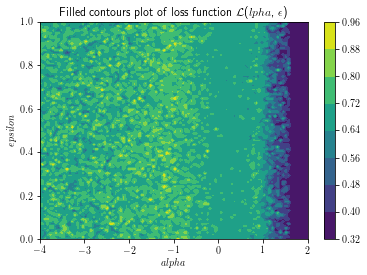

In [102]:
rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\alpha$, $\epsilon$)')
plt.xlabel('$alpha$')
plt.ylabel('$epsilon$')
#à adapter le répertoire de sortie
plt.savefig('./real_loss_contour.png', bbox_inches='tight')
plt.show()

In [107]:
bounds = np.array([[-4,2], [0,1]])

xp, yp = bayesian_optimisation(n_iters=50, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=1000)

C:\Users\timwa\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.46936341e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


C:\Users\timwa\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\timwa\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.46239637e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\timwa\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.46936341e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


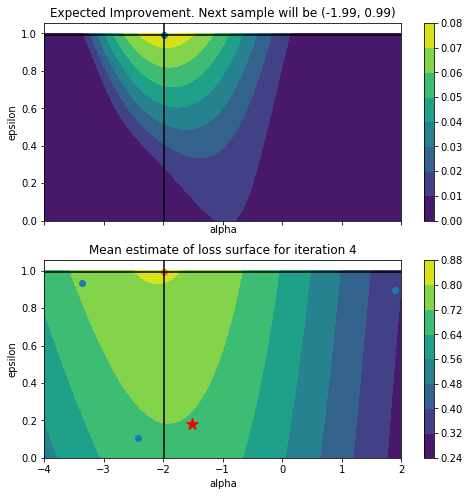

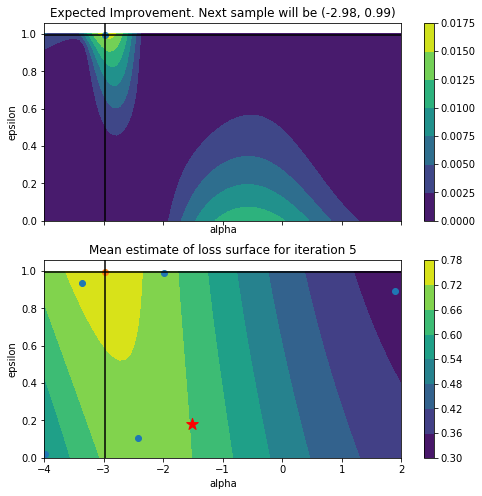

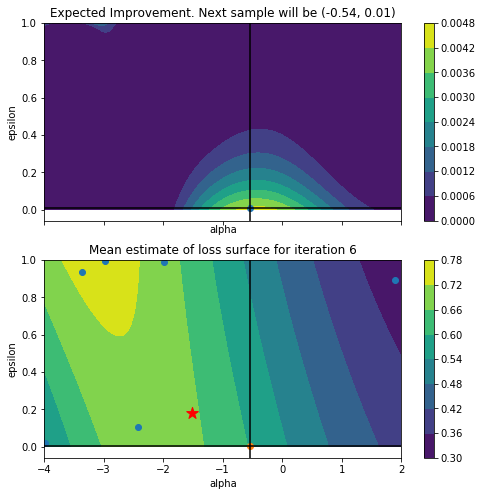

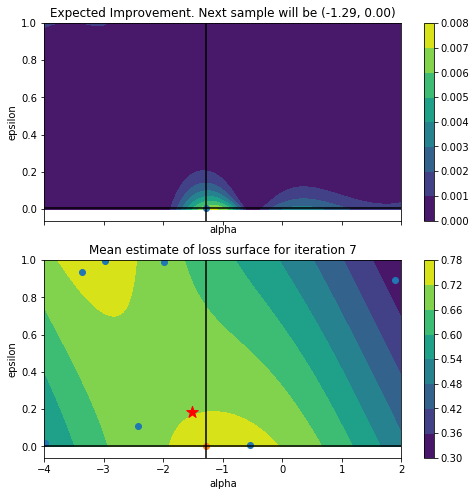

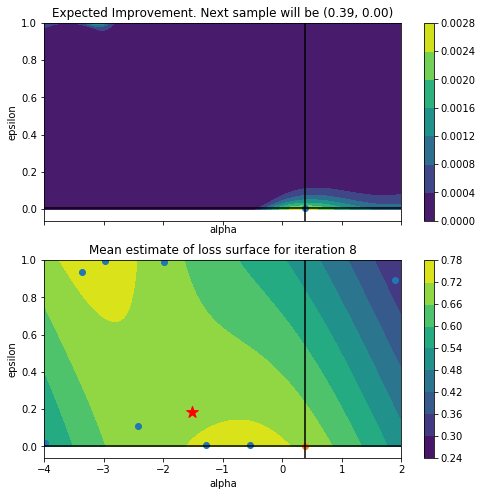

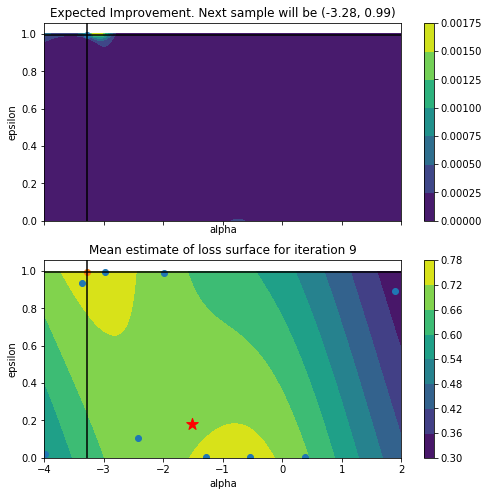

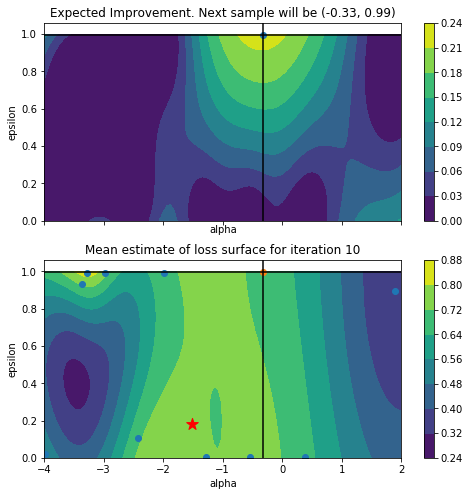

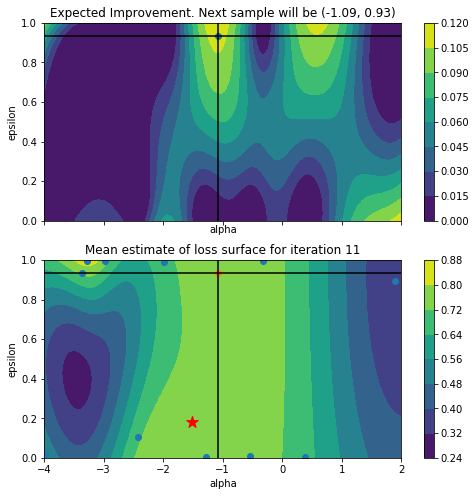

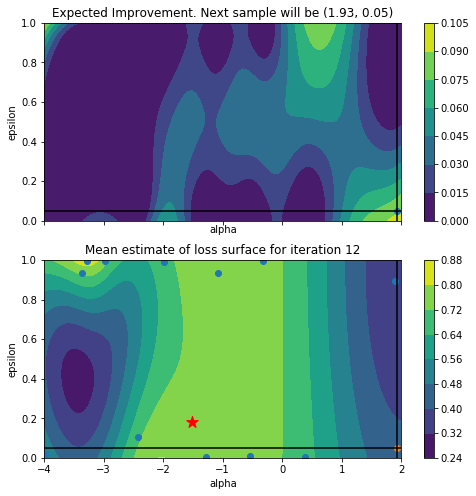

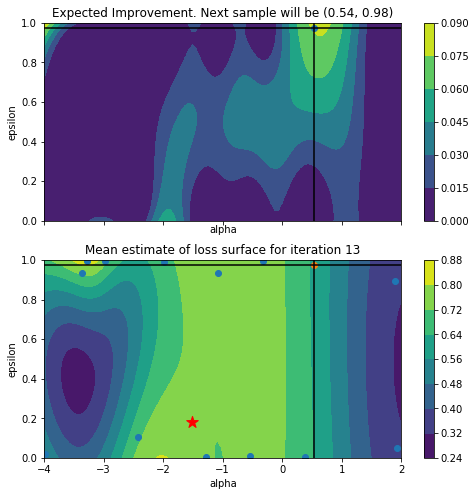

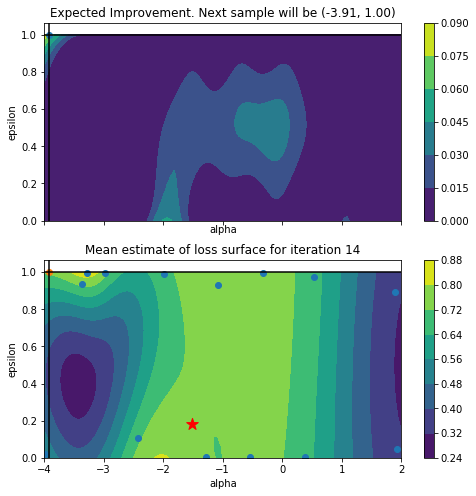

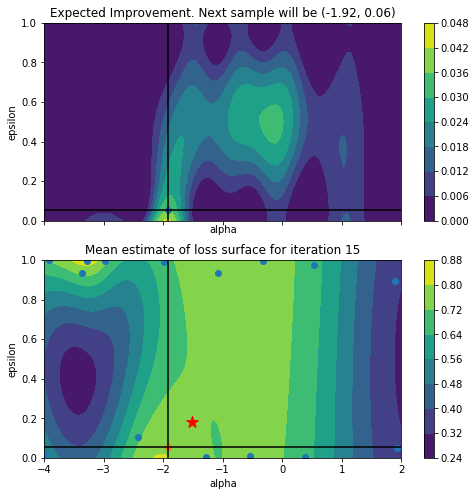

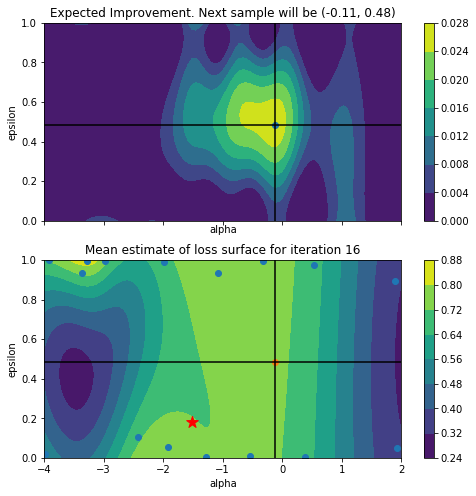

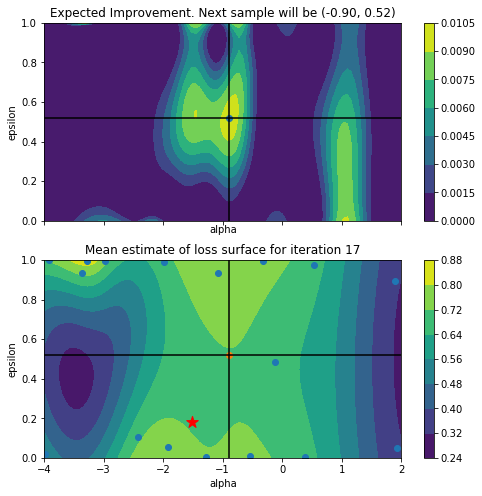

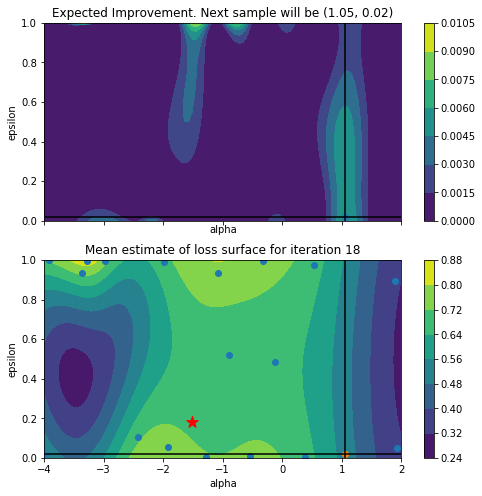

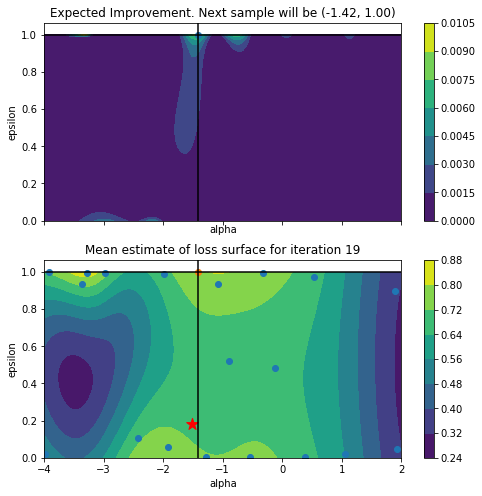

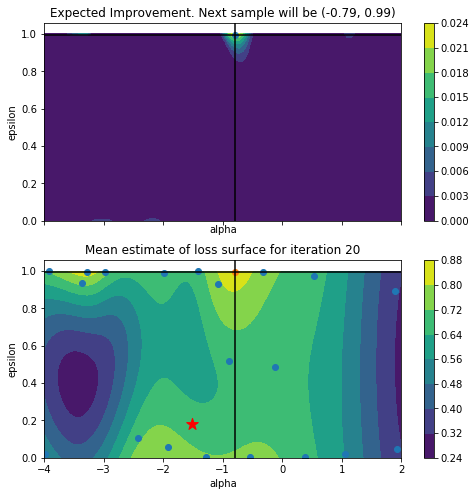

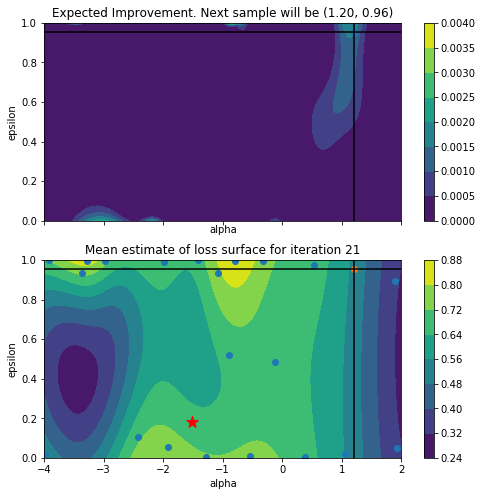

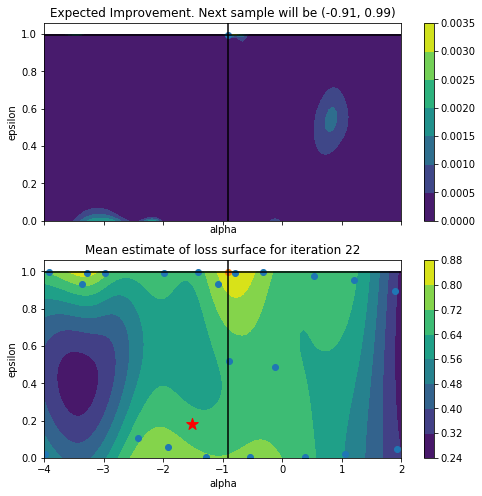

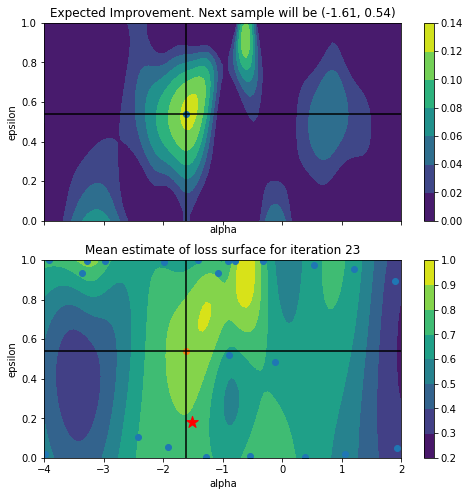

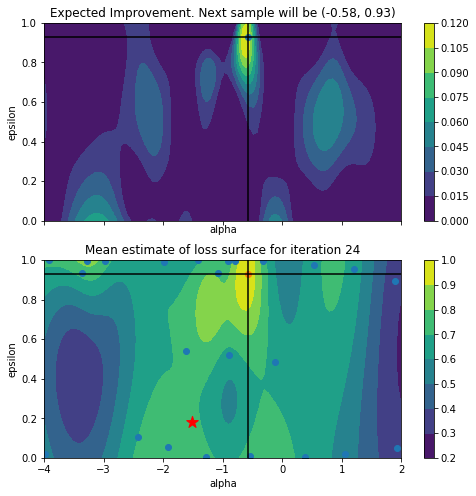

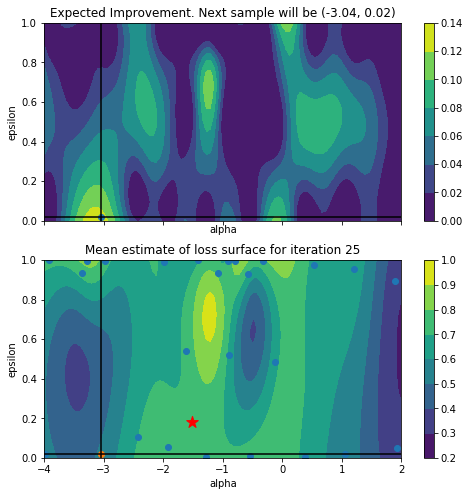

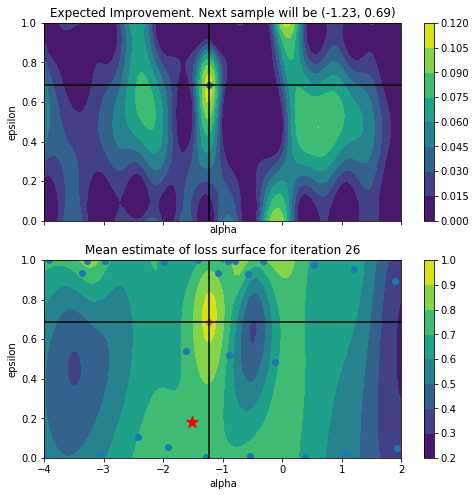

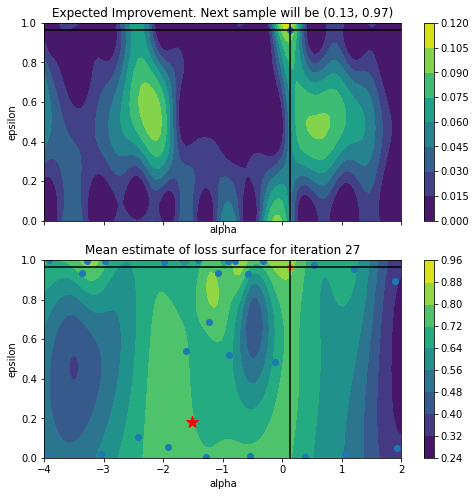

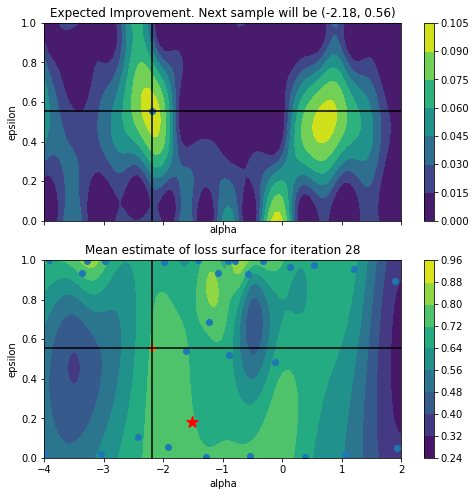

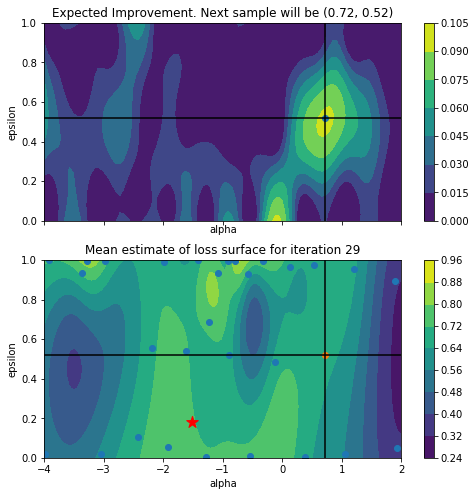

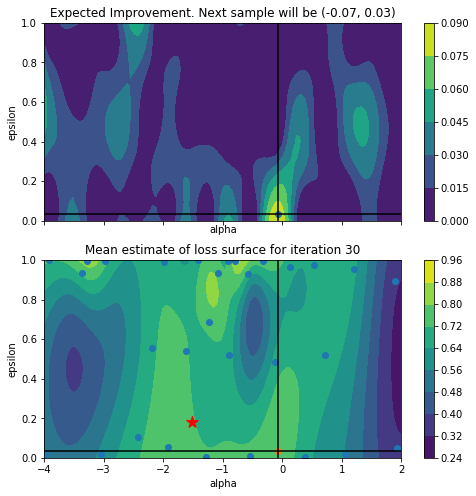

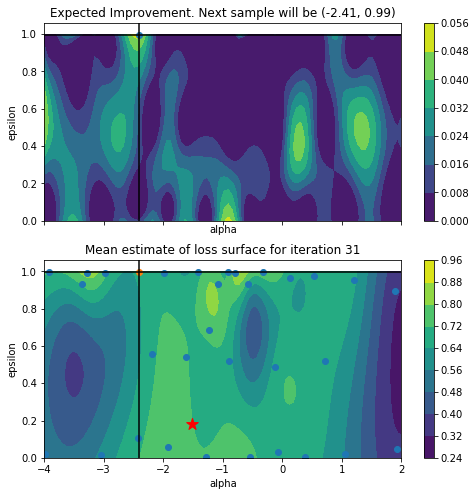

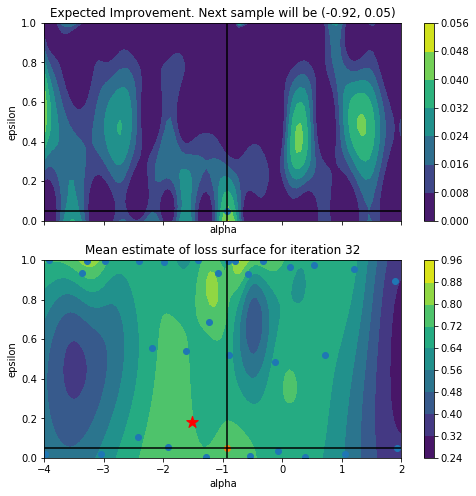

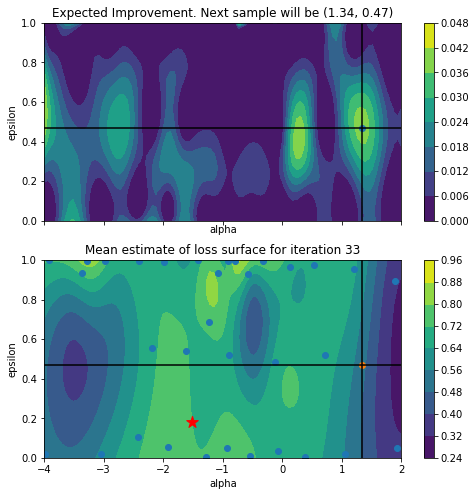

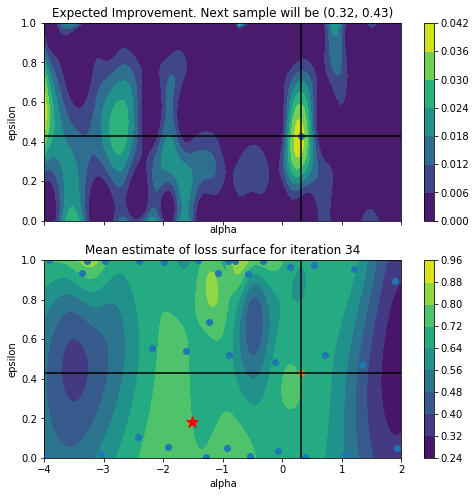

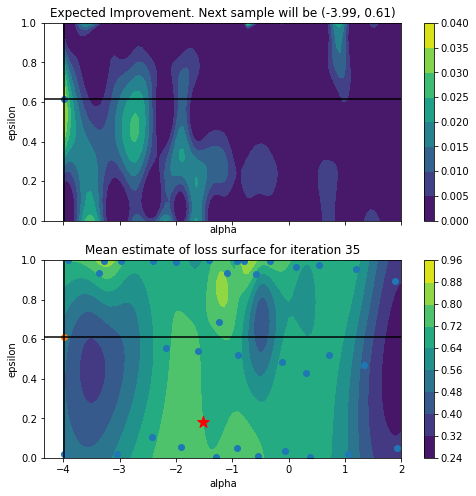

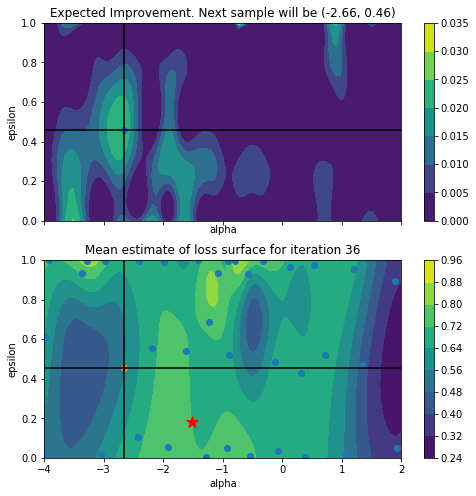

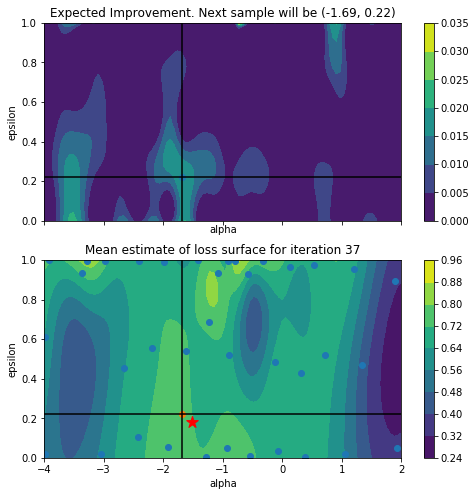

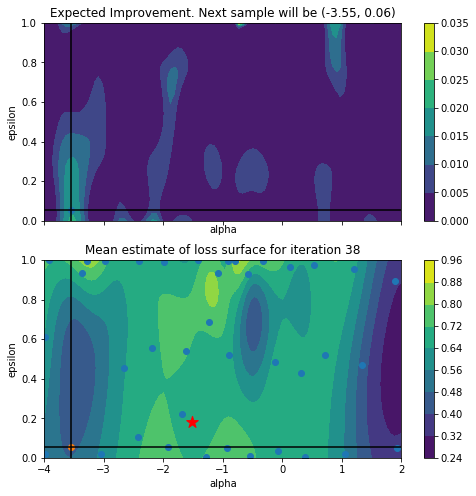

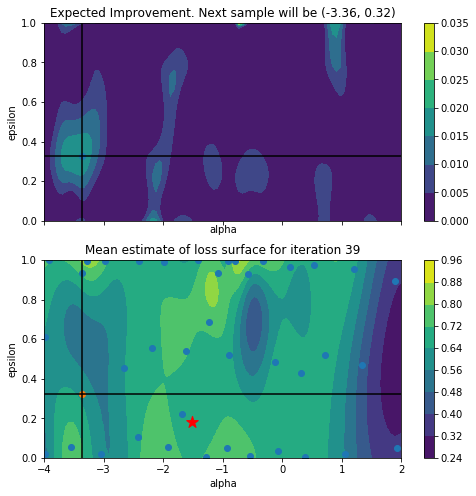

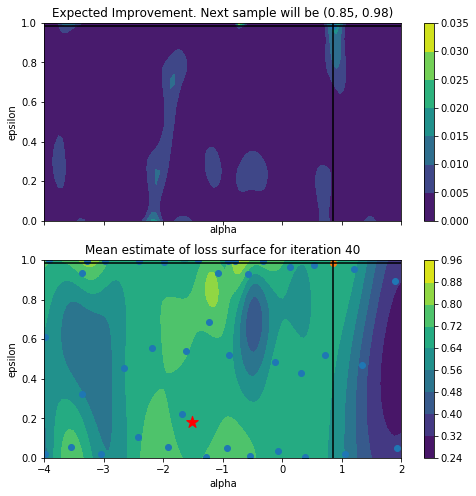

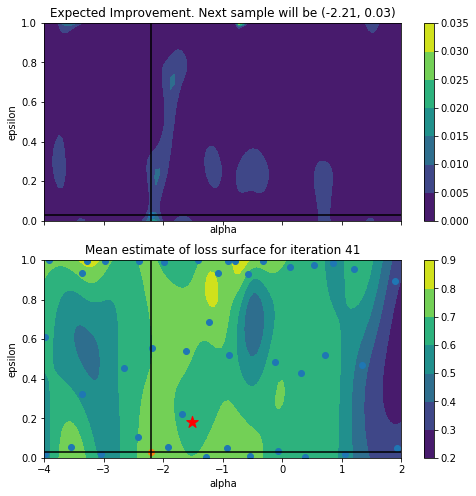

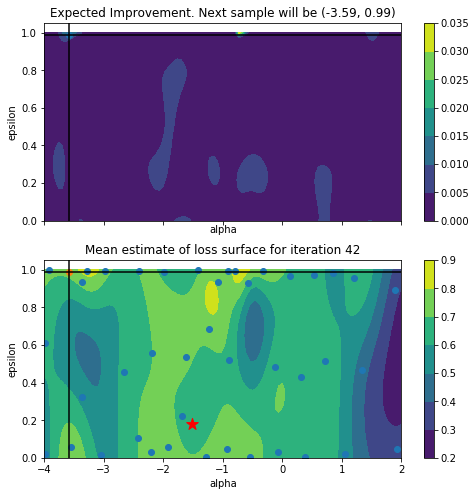

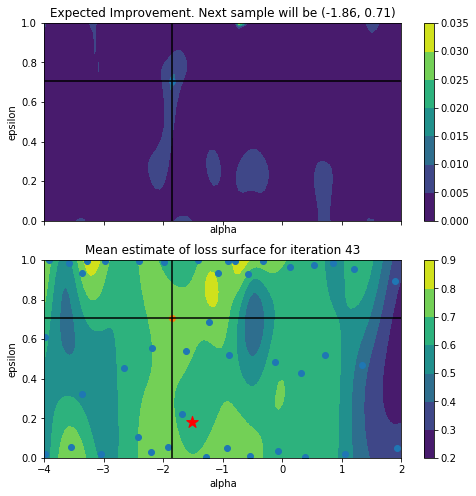

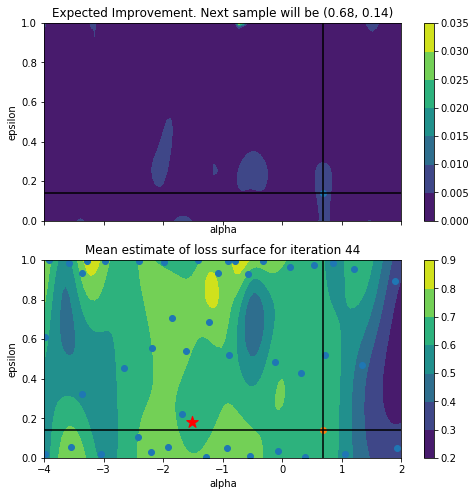

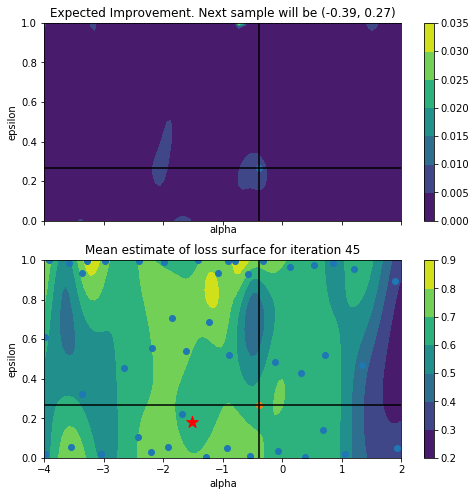

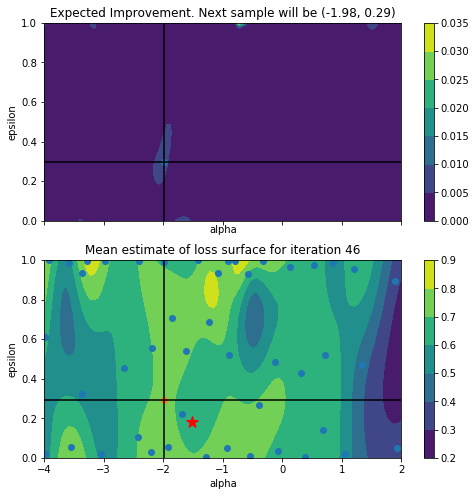

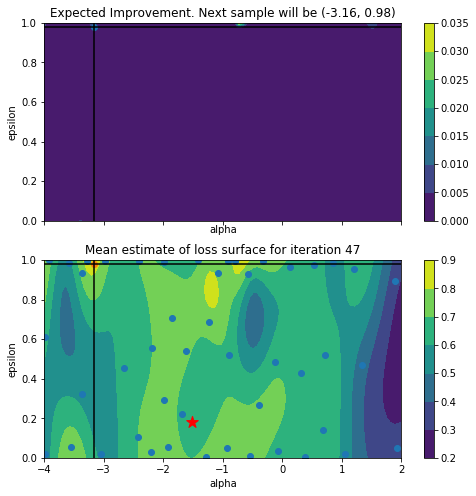

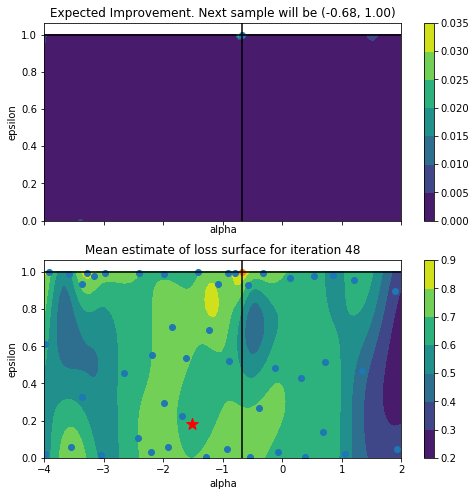

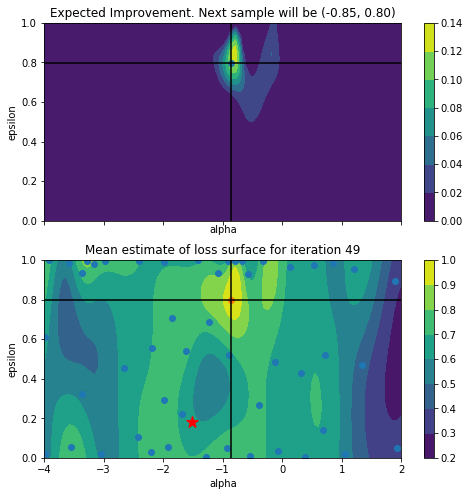

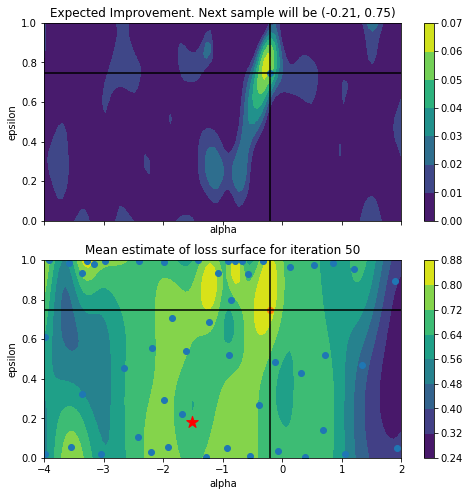

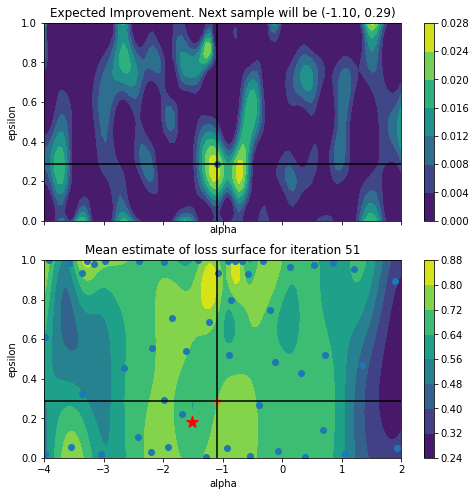

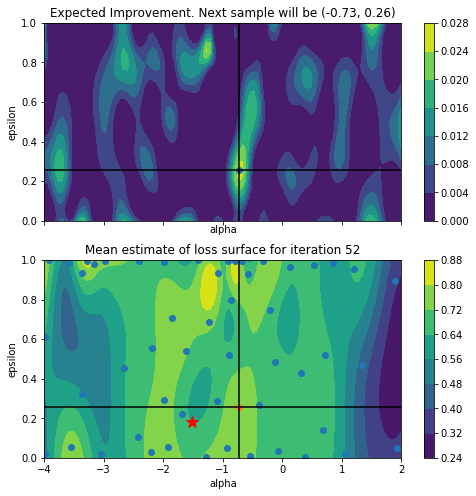

In [108]:
rc('text', usetex=False)
# a adapter le répertoire de sortie des images
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')
#valeur optimum obtenue précédemment avec parma_grid

In [ ]:
from sklearn.svm import SVC
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3).mean()

In [ ]:
lambdas = np.linspace(5, -1, 25)
gammas = np.linspace(-1, -7, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

In [ ]:
from matplotlib import rc
rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma$')
#à adapter le répertoire de sortie
plt.savefig('./real_loss_contour.png', bbox_inches='tight')
plt.show()

In [ ]:
bounds = np.array([[-1, 5], [-7, -1]])
1
xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

In [ ]:
rc('text', usetex=False)
# a adapter le répertoire de sortie des images
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')
#valeur optimum obtenue précédemment avec parma_grid